<a id="TopofBAGofMotifsTutorial_v1"></a>
<h1><font color="blue"> Getting started with Bag-of-Motifs for binary classification</font></h1>

BOM takes as input a table of regulatory region coordinates labeled with one or more cell types/states 

We present a walkthough using snATAC-seq data of whole mouse embryos resolved to 17 cell types (Pijuan-Sala et al 2020) . In this data, snATAC-seq peaks were annotated to cell types based on their differential accessibility compared to other cell types. If working with snATAC-seq data, Signac and ArchR have inbuilt tests to provide sets of marker peaks for each cell cluster which can be used as input. 

Document shortcut links:
<ul><li><a href="#BAGofMotif_Installation">Installation information</a></li>
    <li><a href="#BagOfMotif_QuickStart">Quick start</li>
    <li><a href="#Step1PeakFilter">Step1 Peak Filter</a></li>
    <li><a href="#Step2MotifSearching">Step2 Motif Searching</a></li>
    <li><a href="#Step3MotifCounting">Step3 Motif Counting</a></li>
    <li><a href="#Step4Predicting">Step4 Model Predicting</a></li>
    <li><a href="#Step5SHAP_interpretations">Step5 Shap interpretations</a></li>
    <li><a href="#BOM_references">References</a></li>
</ul>



---
<a id="BAGofMotif_Installation"></a>
<h3><font color="brown">Installation</font></h3>

In [ ]:
# If you havn't done so already install the BagOfMotifs R package. 
# You will need to adjust you local directory for where BagOfMotifs was downloaded.

# setwd("c:/Users/d.humphreys/Documents/GitHub/BOM_package/")
# devtools::build()  # Cannot do this via jupyterlab 

install.packages("~/capsule/data/BagOfMotifs_0.0.2.tar.gz", repos = NULL, type = "source")
install.packages("cowplot")
install.packages("cvAUC")

In [2]:
# Set paths for this vignette
working_path <- '/results/'
setwd(working_path)

# There are a number of example files in package. 
# For the purpose of this vignette we define the required files for the vignette below
# The file mm10.chrom.sizes was downloaded from UCSC (https://hgdownload.soe.ucsc.edu/goldenPath/mm10/bigZips/)
extdata_path <- system.file("extdata",package="BagOfMotifs")
motifs_path  <- paste0(extdata_path,"/gimme.vertebrate.v5.0.meme")
chr_sizes <- paste0(extdata_path, '/mm10.chrom.sizes')


---
<a id="BagOfMotif_QuickStart"></a>
<h3><b><font color="red">Quickstart</font></b></h3>

Starting data is either a bed file of pre-prepared entries or a text file with at least four columns (chromosome, start, stop, cell ID). The function textToBED can be used to produce a bed file out of a text file. For the purpose of this tutorial we will use cell type-specific snATAC-seq for a subset of 4 cell types from the data in Pijuan-Sala et al. 



In [ ]:
# Load example DATA and convert to BED file
extdata_path <- system.file("extdata",package = "BagOfMotifs")

# Load pre-existing data (or replace this with your own)
input_bed <- paste0(working_path,'/mouseE8.25_4CellTypes.bed')
motifs_path  <- paste0(extdata_path,"/gimme.vertebrate.v5.0.meme")
chr_sizes <- paste0(extdata_path, '/mm10.chrom.sizes')
annot <- paste0(extdata_path, '/mm10.knownGene.gtf.gz')

# Filter CREs (generates BED file for each cell type
BagOfMotifs::filterCREs(inputBedFile = input_bed, annotFile = annot, chrSizes = chr_sizes,
                        u = 1000, d = 1000, nbp= 500,
                        keep_proximal = FALSE,
                        remove_proximal = TRUE,
                        non_exonic = TRUE, out_bed = "mouseE8.25_4CellTypes_filt.bed",
                        celloutputDir =  paste0(working_path,"/mouse_E8.25_4ct/")
                        )
# Generate fasta files
generateAllFasta(bedDir = "mouse_E8.25_4ct", genome = Mmusculus, fastaDir = "mouse_E8.25_4ct")

# Identify motifs 
BagOfMotifs::runFIMO(input_path = '/results/mouse_E8.25_4ct/', motifs_path = motifs_path, 
                  out_path = "mouseE8.25_motifs", FIMO_path = '/path/to/fimo', p_thresh = 0.0001)

# Motif count and model training
BagOfMotifs::binModel(target_ct = NULL,
                      data_path = "mouseE8.25_motifs",
                      qval_thresh = 0.5, 
                      outDir = "/results/", nthreads = 2)

# Predicting and producing ROC curves
BagOfMotifs::predict_binary_multi(inputMotif_dir = "./results/"
                                  , inputXGB_dir = "./results/"
                                  , outputTrain_dir = "./results/"
                                  , pred_dir = "./results/"
                                  , outputFile = paste0(resultsDir, "/", "mouseE8.25_ROCs.pdf")
                                  )

# Plor precision/recall curves
prcurve_multi(inputMotif_dir = "./results/"
              , inputXGB_dir = "./results/"
              , outputFile = "./results/mouseE8.25_PRcurvess.pdf")

# Estimate and save SHAP values
save_shap_multi(dataDir = "./results/", outDir = "./results/")

# Visualization of SHAP values

# Bar plots
shapPlots_multi(dataDir = "./results/")

# Beeswarm plots
shapPlots_multi(dataDir = "./results/", plotType = "beeswarm")

# Waterfall plots
shapPlots_multi(dataDir = "./results/", plotType = "watterfall"
                , = CRE_ids = "chr10:104684658-104685158")


---
<a id="Step1PeakFilter"></a>
<h3><font color="brown"> Step_1 Peak filter</font></h3>

<a href="#TopofBAGofMotifsTutorial_v1">back to top of document</a>

The function "filterCREs" filters the peaks. 
Possible filter options within filterCREs include
 
- keeping only regions that are proximal to a transcription start site (TSS)
- keeping only regions located distally
- remove any regions overlapping exons
- adjust the width of the regions to ensure concistency. 


Required arguments:
- 'input_bed' : provide peak data in .bed format.
- 'annot'     : provide a genome annotation file (*.gtf).
- 'chr_sizes' : provide a genome size file.
- 'out_bed'   : provide a output filename.


**In this walkthrough**, we focus on cell-type specific distal elements so we remove the peaks located within 1kb from a TSS and the peaks overlapping exons. We also adjust the width of each element so that each peak is centered and spans 500bp. We also remove peaks that are annotated to multiple cell types as well.

A gencode mm10 mouse gene model is attached to this package and is used in the code below.


In [3]:
date() # takes ~2mins to complete

library(GenomicFeatures)
library(GenomicRanges)
library(BagOfMotifs)

chr_sizes <- "mm10.chrom.sizes"
extdata_path <- system.file("extdata",package = "BagOfMotifs")
annot <-  paste0(extdata_path, "/mm10.knownGene.gtf.gz")

# The following is the same file generated above and saved to /results/mouseE8.25_4CellTypes.bed
input_bed <- paste0(extdata_path,'/tutorial/mouseE8.25_4CellTypes.bed')

# chr_sizes <- paste0(extdata_path, '/mm10.chrom.sizes')
BagOfMotifs::filterCREs(inputBedFile = input_bed, annotFile = annot, chrSizes = chr_sizes,
                        u = 1000, d = 1000, nbp= 500,
                        keep_proximal = FALSE,
                        remove_proximal = TRUE,
                        non_exonic = TRUE, out_bed = "mouseE8.25_4CellTypes_filt.bed",
                        celloutputDir =  paste0(working_path,"/mouse_E8.25_4ct/")
                        )
date()

[1] "Mon Dec 18 19:21:27 2023"

Reading CREs...


Reading genome annotation...


Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
OK

Removing exonic regions...


Removing proximal regions to TSSs...




Reading chromosome sizes...
Adjusting CRE length...


Saving 3995 CREs...


Preparing output directories and files so that everything is set for motif searching

The following files have been prepared: 
Endothelium.bed
Cardiomyocytes.bed
Erythroid.bed
Allantois.bed



[1] "Mon Dec 18 19:22:10 2023"

---
<a id="Step2MotifSearching"></a>
<h3><font color="brown"> Step_2 Motif Searching</font></h3>

<a href="#TopofBAGofMotifsTutorial_v1">back to top of document</a>

**Note ** this step  requires that your computer has an installation of the **MEME suite**. The vertebrate motifs from the [database GIMME Motifs](https://github.com/vanheeringen-lab/gimmemotifs) [2] are used in the tutorial. 

This step identifies transcription factor (TF) binding motifs within the CRE using FIMO from the MEME suite.



There are two options to annotate peaks.
In general, Fimo is fast. Files that have ~1000 peaks will take approximately 5 minutes to compute. But if you have more regions consider using the command line

1. BagOfMotifs R package function: **runFIMO**. 









In [ ]:
# Fist we generate fasta files for the peaks specific to each cell type
library("BSgenome.Mmusculus.UCSC.mm10")
Mmusculus <- BSgenome.Mmusculus.UCSC.mm10::BSgenome.Mmusculus.UCSC.mm10

generateAllFasta(bedDir = "mouse_E8.25_4ct", genome = Mmusculus, fastaDir = "mouse_E8.25_4ct")

# Next we execute runFIMO function to find motif instances in CREs
motifs_path <- paste0(extdata_path, "/gimme.vertebrate.v5.0.meme")

BagOfMotifs::runFIMO(input_path = 'mouse_E8.25_4ct', motifs_path = motifs_path, p_thresh = 0.0001, 
                   out_path = "mouseE8.25_motifs", FIMO_path = '/g/data/zk16/cc3704/meme/meme-5.4.0/src/')

2. Run fimo using gnu parallel on the command line

    Here is an example of how to run FIMO using bash parallel via bash command line 

    cd directory_containing_fastaFiles <br>

    mkdir mouseE8.25_motifs<br>

    ls *.fasta | parallel fimo --thresh 0.001 --o {.} gimme.vertebrate.v5.0.meme mouseE8.25_motifs/{}



---
<a id="Step3MotifCounting"></a>
<h3><font color="brown"> Step_3 Motif counting and model training</font></h3>

<a href="#TopofBAGofMotifsTutorial_v1">back to top of document</a>



In this step, the motif counts matrix will be prepared for binary classification, by running <code>binModel</code> function. Every matrix for binary classification contains a similar number of positive (target cell type CREs) and negative instances (background). Non-target cell types are equally represented in the background set.

Required arguments for this function include

- 'target_ct'   : Target cell type condition
- 'data_path'   : Path to directoy containing motifs
- 'qval_thresh' : q value threshold
- 'outDir'      : Name of directory to save output files. Output files will be named cellType_vs_Others

<a href="#TopofBAGofMotifsTutorial_v1">Back to top of document</a>

In [7]:
# prepare counts for binary classifications
# Leaving target_ct as NULL means all cell types will be processed
date() # takes ~2-3 mins to run for all celltypes 

library(doParallel)
library(xgboost)
library(devtools)
library(withr)

binModel(target_ct = NULL, data_path = "mouseE8.25_motifs", qval_thresh = 0.5
        , early_stopping_rounds = 100, print_every_n = 100, nthread = 2
         , outDir = "mouseE8.25_results")


date()

[1] "Mon Dec 18 20:11:54 2023"

Reading input data from mouseE8.25_motifs.
There are 4 directories found.

Writing output

Processing all cell types

Training....

Preparing training for Allantois

Saving CRE ids of training, validation and test sets...

Preparing training for Cardiomyocytes

Saving CRE ids of training, validation and test sets...

Preparing training for Endothelium

Saving CRE ids of training, validation and test sets...

Preparing training for Erythroid

Saving CRE ids of training, validation and test sets...

Complete



[1] "Mon Dec 18 20:12:34 2023"

In the output matrix, every CRE will be represented by a row and columns represent different motifs. The last 2 columns contain the cell type annotation, "celltype" contains the actual cell type name and "binary_celltype" contains the cell tipy coded as a binary, 1 represents cardiomyocyte CRE and 0 represents background CRE.


In [10]:
counts <- read.table(file = "./mouseE8.25_results/Cardiomyocytes_vs_Others.txt", header = T, 
                     stringsAsFactors = F, sep = '\t')
head(counts[,c(head(colnames(counts)), tail(colnames(counts), 2))])

,GM.5.0.AP.2.0001,GM.5.0.AP.2.0002,GM.5.0.AP.2.0003,GM.5.0.AP.2.0004,GM.5.0.AP.2.0005,GM.5.0.AP.2.0006,celltype,binary_celltype
,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>
chr10:111680833-111681333,0,0,0,0,0,0,Erythroid,0
chr10:114633874-114634374,0,0,0,1,0,0,Endothelium,0
chr10:116266783-116267283,0,0,0,0,0,0,Endothelium,0
chr10:117732122-117732622,1,2,2,0,0,0,Erythroid,0
chr10:121962019-121962519,0,0,0,0,0,0,Endothelium,0
chr10:121971621-121972121,0,0,0,0,0,0,Endothelium,0


---
<a id="Step4Predicting"></a>
<h3><font color="brown"> Step_4 Predicting</font></h3>

<a href="#TopofBAGofMotifsTutorial_v1">back to top of document</a>

Now, we use the trained models to predict on the tests set, by using **"predict_binary"** function. 




In [10]:
setwd("/g/data/zk16/cc3704/tools/R/bom_tests")

In [3]:
BagOfMotifs::predict_binary_multi(inputMotif_dir = "./mouseE8.25_results/"
                                  , inputXGB_dir = "./mouseE8.25_results/"
                                  , outputTrain_dir = "./mouseE8.25_results/"
                                  , pred_dir = "./mouseE8.25_results/"
                                  , outputFile = "./mouseE8.25_results/mouseE8.25_ROCs.pdf")

Loading required package: cowplot

Preparing Allantois_vs_Others predict binary output

Preparing Cardiomyocytes_vs_Others predict binary output

Preparing Endothelium_vs_Others predict binary output

Preparing Erythroid_vs_Others predict binary output



png 
  2

![ROC_curves](./mouseE8.25_ROCs.png)

The output file contains 3 columns. The first column indicates the true class of the CRE, 1 representing cardiomyocyte CRE and 0 representing background CRE. The second column represents the predicted classes coded as a binary with a threshold of > 0.5. The last column represents the predicted probability by the model. We can use these values to calculate some metrics of performance. 

Output values for the area under the Receiver Operating Characteristic (ROC) curve (auROC), area under the precision/recall curve (auPR), accuracy, F1 score, recall and precision and provided for all cell types. ROC curves and a precision/recall curves are also provided in the output.


We can generate precision/recall curves across all the models with the function **"prcurve_multi"**

In [11]:
prcurve_multi(inputMotif_dir = "./mouseE8.25_results/"
              , inputXGB_dir = "./mouseE8.25_results/"
              , outputFile = "./mouseE8.25_results/mouseE8.25_PRcurvess.pdf")

Preparing Allantois_vs_Others predict binary output

Preparing Cardiomyocytes_vs_Others predict binary output

Preparing Endothelium_vs_Others predict binary output

Preparing Erythroid_vs_Others predict binary output



png 
  2

![PR_curves](./mouseE8.25_PRcurvess.png)

We can save the prediction statistics across all the models using the function **"save_binStats"**. We can either provide a list of files containing binary predictions or a directory where the files are located (files ending in *pred.txt).

In [18]:
save_binStats(pred_dir = "./mouseE8.25_results", out_file = "./mouseE8.25_results/binStats")

Using files ending with pattern 'pred.txt'



In [20]:
# Looking at the binary prediction statistics
stats <- read.table(file = "./mouseE8.25_results/binStats", header =T)
stats

Model,Accuracy,auPR,auROC,F1,MCC,Precision,Recall
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Allantois_vs_Others,0.942,0.996,0.996,0.940,0.888,0.986,0.899
Cardiomyocytes_vs_Others,0.951,0.995,0.995,0.951,0.902,0.959,0.943
Endothelium_vs_Others,0.933,0.990,0.987,0.934,0.870,0.978,0.895
Erythroid_vs_Others,0.962,0.990,0.990,0.964,0.926,0.939,0.990


---
<a id="Step5SHAP_interpretations"></a>
<h3><font color="brown"> Step_5 SHAP interpretations </font></h3>

BOM leverages the usage of SHapley Additive exPlanations (SHAP) to estimate the contribution of each TF binding motif to the classification tasks (Lundberg et al 2020). SHAP values are calculated for each TF binding motif (columns) and for each CRE (rows) in the training set. X-axis represent log-odds units, before logistic link function. A positive SHAP value represents a contribution towards a positive outcome (CRE being classified as the target class/cell type/state) whereas a negative value represents a contribution towards the negative/background class. The magnitude of SHAP values is also informative, a high absolute value represents a higher contribution.

By using the function **"save_shap"** for a single model or **"save_shap_multi"** for multiple models, SHAP values will be saved to a file. The examples below show how to save SHAP values. You can either provide a list of models and training sets or a path to the data.

In [ ]:
save_shap_multi(dataDir = "./mouseE8.25_results/", outDir = "./mouseE8.25_results/")

Using the SHAP values we can produce a series of plots to explore the importance of TF binding motifs in the classification tasks. The different plot options are summarized below:

**Bar plot:**
SHAP barplots represent a ranking of the most important motifs for the classification tasks across all CREs (y-axis). By default, the values shown in the x-axis of this type of plot are the mean of |SHAP| for each TF binding motif across all CREs, however the user can choose the sum of |SHAP| instead.

**Beeswarm plot:**
In a beeswarm plot, the Y-axis also represents the TF binding motif ranking, by default, based on the sum of |SHAP| across CREs. In this type of plot each CRE is represented by a dot and the SHAP scores are signed values centered on zero (x-axis). Dots are coloured by the TF binding motif count normalised to 0-1 range.

**Watterfall plot:**
Waterfall plots represent the contribution of the most important TF binding motifs in the classification task. Positive and negative SHAP values are represented by arrows in oposite directions. Motifs are ranked by the magnitude of their contribution. The sign and magnitude or the SHAP score is shown in each case. Additionally, waterfall plots show predicted value of the model, denoted as 'F(x)'. The mean prediction value across all CREs is also shown ('E[f(x)]').

Waterfall plots can display the SHAP values of single CREs or CRE sets, at least one CRE ID should be specified. If multiple CRE IDs are provided and if average_shap is set to TRUE (default), the average SHAP across the CREs specified will be displayed. If average_shap is FALSE, o set of waterfall plots will be produced, one for each CRE.


<a href="#TopofBAGofMotifsTutorial_v1">back to top of document</a>

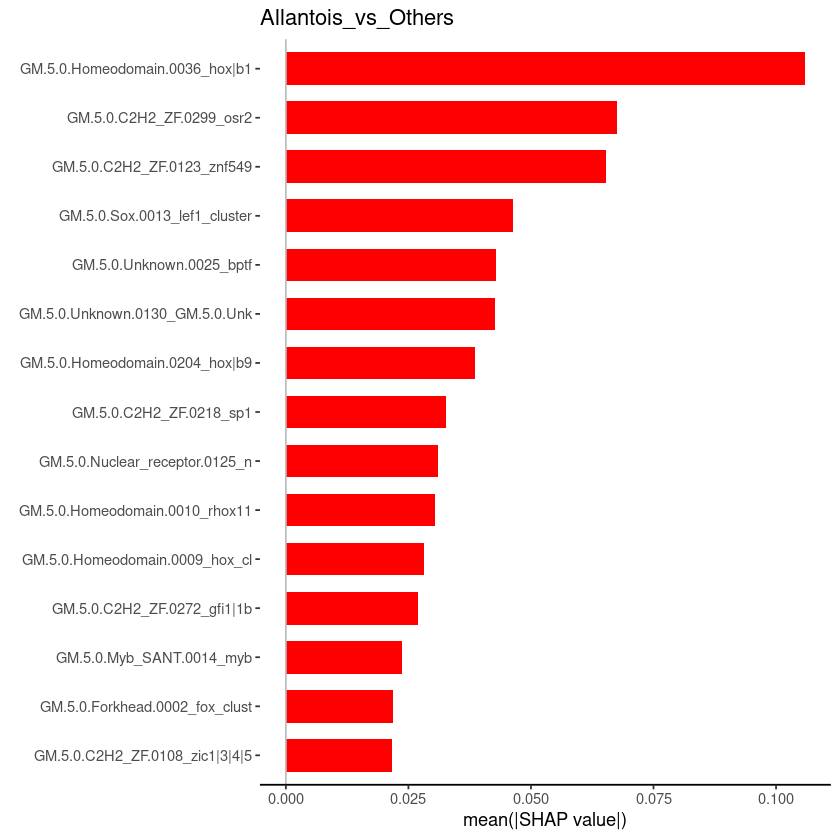

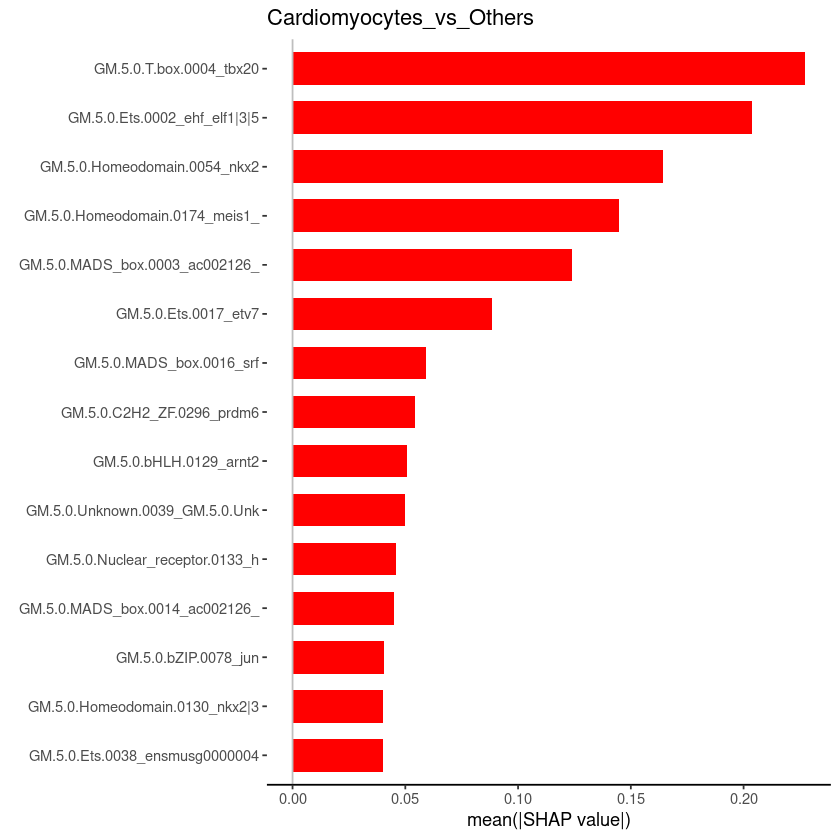

[[1]]

[[2]]

[[3]]

[[4]]


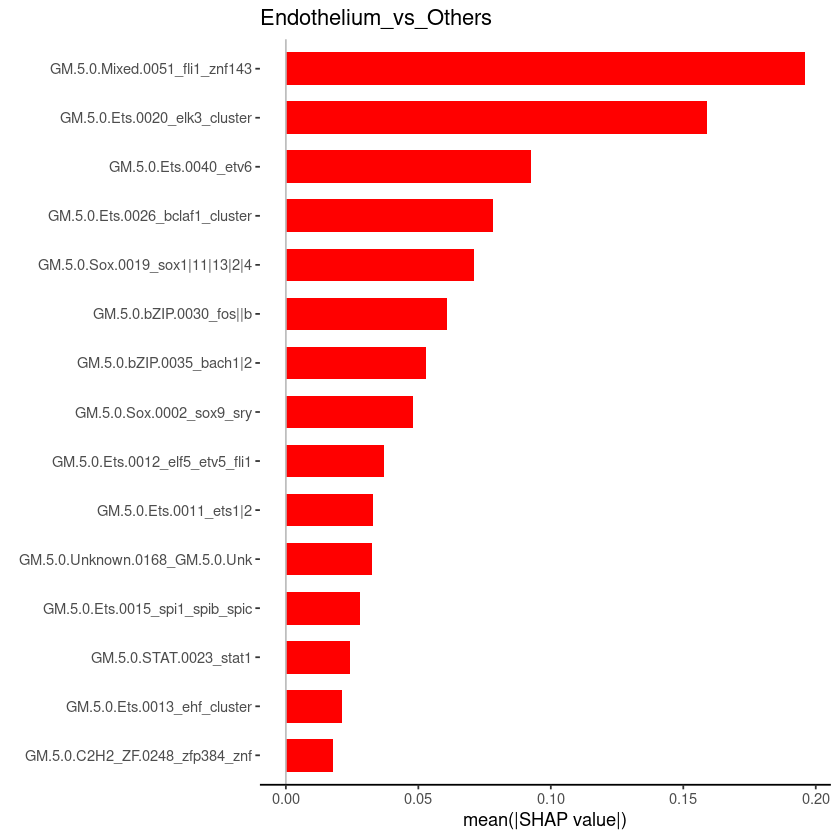

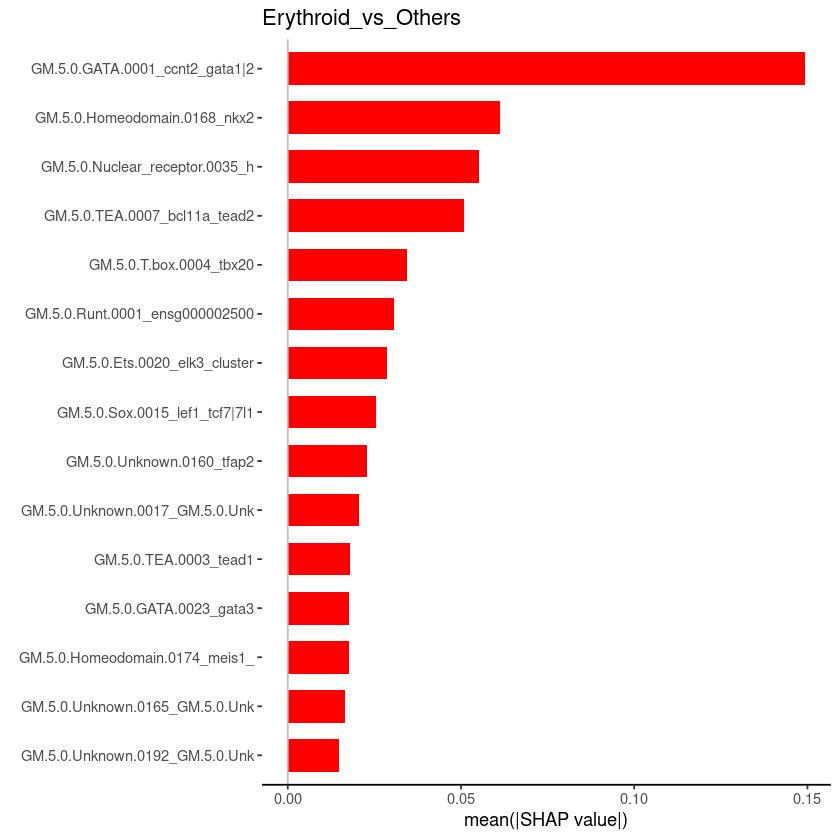

In [25]:
library("shapviz")
library("gggenes")
library("shades")

# Load summary annotation table which is provided in BagOfMotifs package. 
extdata_path <- system.file("extdata",package = "BagOfMotifs")
gimme.fn <- paste0(extdata_path,"/gimme.vertebrate.v5.0.annot_summarized_shorten.txt.gz")
gimme_annot <- read.table(gimme.fn,header = TRUE, fill = TRUE)


# By providing the path to the models and training sets, a plot will be produced for each model. 
# If we provide annotDat then the Y-axis will populate with both the motif ID plus the transcription factor name
# Note the default is to truncate the Y-axis labels to 30 characters as some names interfere with plot sizes. 
# This can be changed with parameter annotLength.
# If parameter annotDat is not provided then only the generic motif name is used for labels
p <- shapPlots_multi(dataDir = "./mouseE8.25_results/", annotDat = gimme_annot)
models <- list.files(path = "./mouseE8.25_results/", pattern="(.*)rds$")

# adding titles
for(i in 1:length(p)){p[[i]] <- p[[i]] + ggtitle(sub(".rds", "", models[i]))}
p

In [ ]:
extdata_path <- system.file("extdata",package = "BagOfMotifs")
gimme.fn <- paste0(extdata_path,"/gimme.vertebrate.v5.0.annot_summarized_shorten.txt.gz")
gimme_annot <- read.table(gimme.fn,header = TRUE, fill = TRUE)

p <- shapPlots_multi(dataDir = "./mouseE8.25_results/", plotType = "beeswarm", annotDat = gimme_annot)

# Model names
models <- list.files(path = "./mouseE8.25_results/", pattern="(.*)rds$")

# adding titles
for(i in 1:length(p)){p[[i]] <- p[[i]] + ggtitle(sub(".rds", "", models[i]))}
p

In [ ]:
xgb_model <- readRDS("./mouseE8.25_results/Cardiomyocytes_vs_Others.rds")
train_set <- read.table(file = "./mouseE8.25_results/Cardiomyocytes_vs_Others_train.txt", header = TRUE)

# Local explanation of a cardiomyocyte CRE ("chr10:104684658-104685158") in the cardiomyocyte model
# Note that producing multiple waterfall plots across multiple models using the function "shapPlots_multi" will produce warnings if the CRE is not present in all the datasets.
shapPlots(xgb_model = xgb_model, ts = train_set
               , plotType = "waterfall", max_display = 10
               , CRE_ids = "chr10:104684658-104685158"
               , annotDat = gimme_annot)

In [26]:
sessionInfo()

R version 4.0.0 (2020-04-24)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Rocky Linux 8.8 (Green Obsidian)

Matrix products: default
BLAS/LAPACK: /apps/intel/compilers_and_libraries_2019.5.281/linux/mkl/lib/intel64_lin/libmkl_intel_lp64.so

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggpubr_0.4.0                       yardstick_1.2.0                   
 [3] BagOfMotifs_0.0.3                  ggplot2_3.3.5                     
 [5] pROC_1.18.0                        cvAUC_1.1.4                       
 [7] cowplot_1.1.1                      shades_1.4.0                      
 [9] gggenes_0.5.1               

---
<a id="BOM_references"></a>
<h3><font color="brown"> References</font></h3>

<a href="#TopofBAGofMotifsTutorial_v1">back to top of document</a>

1. Pijuan-Sala, B., Wilson, N. K., Xia, J., Hou, X., Hannah, R. L., Kinston, S., ... & Göttgens, B. (2020). Single-cell chromatin accessibility maps reveal regulatory programs driving early mouse organogenesis. Nature cell biology, 22(4), 487-497.
2. Bruse, N., & Heeringen, S. J. V. (2018). GimmeMotifs: an analysis framework for transcription factor motif analysis. BioRxiv, 474403.
3. Charles E. Grant, Timothy L. Bailey and William Stafford Noble, "FIMO: Scanning for occurrences of a given motif", Bioinformatics 27(7):1017-1018, 2011. [full text]
4. Quinlan, A. R., & Hall, I. M. (2010). BEDTools: a flexible suite of utilities for comparing genomic features. Bioinformatics, 26(6), 841-842.
5. Lundberg, S. M., Erion, G., Chen, H., DeGrave, A., Prutkin, J. M., Nair, B., ... & Lee, S. I. (2020). From local explanations to global understanding with explainable AI for trees. Nature machine intelligence, 2(1), 56-67.